<a href="https://colab.research.google.com/github/seymadogru/BasicDataTypes/blob/master/warehouse_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import gym
from gym import spaces
import numpy as np
import time
from IPython.display import clear_output

class SmartBatchLogisticsEnv(gym.Env):
    def __init__(self):
        super(SmartBatchLogisticsEnv, self).__init__()

        self.grid_size = 12
        self.map = np.zeros((self.grid_size, self.grid_size), dtype=int)

        self._generate_map()

        self.action_space = spaces.Discrete(5)

        # Gözlem: [RobotX, RobotY, Slot1, Slot2]
        low = np.array([0, 0, 0, 0])
        high = np.array([self.grid_size, self.grid_size, 6, 6])
        self.observation_space = spaces.Box(low, high, dtype=np.int32)

        self.agent_pos = [0, 0]
        self.slots = [0, 0]
        self.order_list = []
        self.max_steps = 600
        self.current_step = 0

    def _generate_map(self):
        self.map.fill(0)
        self.map[0, 0] = 2 # DOCK

        for _ in range(25):
            x, y = np.random.randint(1, 11, 2)
            self.map[x, y] = 1

        self.shelves = {
            1: [11, 11], 2: [0, 11], 3: [11, 5], 4: [5, 5], 5: [5, 0]
        }
        for k, pos in self.shelves.items():
            self.map[pos[0], pos[1]] = 10 + (k-1)

    def reset(self):
        self.agent_pos = [0, 0]
        self.slots = [0, 0]
        self.current_step = 0
        self.order_list = list(np.random.choice([1, 2, 3, 4, 5], 12)) # 12 Ürünlük yoğun liste
        return self._get_obs()

    def _get_obs(self):
        return np.array([self.agent_pos[0], self.agent_pos[1], self.slots[0], self.slots[1]])

    def _dist(self, pos1, pos2):
        return abs(pos1[0] - pos2[0]) + abs(pos1[1] - pos2[1])

    def step(self, action):
        self.current_step += 1
        reward = -0.1
        done = False

        prev_pos = self.agent_pos.copy()

        # Hareket
        if action == 0: self.agent_pos[0] = max(0, self.agent_pos[0] - 1)
        elif action == 1: self.agent_pos[0] = min(self.grid_size - 1, self.agent_pos[0] + 1)
        elif action == 2: self.agent_pos[1] = max(0, self.agent_pos[1] - 1)
        elif action == 3: self.agent_pos[1] = min(self.grid_size - 1, self.agent_pos[1] + 1)

        if self.map[self.agent_pos[0], self.agent_pos[1]] == 1:
            reward -= 1
            self.agent_pos = prev_pos

        # --- AKILLI HEDEF BELİRLEME (Heuristic Reward) ---
        target_pos = None

        # 1. STRATEJİ: DOLDURMA
        # Eğer çanta boşsa VEYA (Yarı dolu VE Listede hala mal var) -> DOCK HEDEF
        # Yani: "Yerim var ve iş var, neden boş gideyim?" mantığı
        has_space = (0 in self.slots)
        has_orders = (len(self.order_list) > 0)
        is_empty = (sum(self.slots) == 0)

        if is_empty and has_orders:
            target_pos = [0, 0] # Kesin dön
        elif has_space and has_orders:
            # Burası kritik: Eğer Dock'a çok yakınsa geri dönüp alması mantıklı,
            # ama çok uzaktaysa elindekini bırakması mantıklı.
            # Şimdilik basitleştirelim: Tam kapasite çalışmayı teşvik edelim.
             target_pos = [0, 0]

        # 2. STRATEJİ: DAĞITMA (Rota Optimizasyonu)
        # Eğer çanta doluysa (veya liste bitti ama elde mal var)
        if sum(self.slots) > 0:
            # Çantadaki ürünlerin hedeflerine bak
            targets = []
            if self.slots[0] > 0: targets.append(self.shelves[self.slots[0]])
            if self.slots[1] > 0: targets.append(self.shelves[self.slots[1]])

            # Bulunduğum yere EN YAKIN olan rafı hedef seç
            if len(targets) > 0:
                dists = [self._dist(self.agent_pos, t) for t in targets]
                closest_idx = np.argmin(dists)
                target_pos = targets[closest_idx]

        # Rehberlik Ödülü (Sıcak/Soğuk)
        if target_pos:
            d_old = self._dist(prev_pos, target_pos)
            d_new = self._dist(self.agent_pos, target_pos)
            if d_new < d_old: reward += 0.2
            elif d_new > d_old: reward -= 0.1

        # --- ETKİLEŞİM ---
        curr_cell = self.map[self.agent_pos[0], self.agent_pos[1]]

        if action == 4:
            # DOCK (Yük Alma - FULL KAPASİTE)
            if curr_cell == 2:
                loaded_count = 0
                # Boş yer olduğu sürece ve listede mal olduğu sürece yükle
                while 0 in self.slots and len(self.order_list) > 0:
                    empty_idx = self.slots.index(0)
                    item = self.order_list.pop(0)
                    self.slots[empty_idx] = item
                    loaded_count += 1

                if loaded_count > 0:
                    # Eğer 2 tane birden aldıysa BÜYÜK ÖDÜL ver
                    if loaded_count == 2: reward += 50
                    else: reward += 20
                else:
                    reward -= 2 # Boşuna etkileşime girme

            # RAF (Yük Bırakma)
            elif curr_cell >= 10:
                shelf_type = curr_cell - 10 + 1
                delivered = False
                for i in range(2):
                    if self.slots[i] == shelf_type:
                        self.slots[i] = 0
                        reward += 60
                        delivered = True
                        break
                if not delivered: reward -= 2
            else:
                reward -= 1

        if len(self.order_list) == 0 and sum(self.slots) == 0:
            reward += 100
            done = True

        if self.current_step >= self.max_steps:
            done = True

        return self._get_obs(), reward, done, {}

    def render(self):
        print(f"\n--- AKILLI BATCHING SİSTEMİ ---")
        s1 = chr(64+self.slots[0]) if self.slots[0]>0 else "-"
        s2 = chr(64+self.slots[1]) if self.slots[1]>0 else "-"
        # Görsel feedback: Dolu kapasite mi?
        status = "TAM KAPASİTE" if (self.slots[0]>0 and self.slots[1]>0) else "YARI KAPASİTE" if sum(self.slots)>0 else "BOŞ"

        print(f"YÜK DURUMU: [📦 {s1}] [📦 {s2}] ({status})")
        print(f"KALAN SİPARİŞ: {len(self.order_list)}")
        list_str = " -> ".join([chr(64+x) for x in self.order_list[:5]])
        if len(self.order_list) > 5: list_str += " ..."
        print(f"LİSTE: {list_str}")
        print("-" * 30)

        for x in range(self.grid_size):
            row = ""
            for y in range(self.grid_size):
                cell = self.map[x, y]
                if x==self.agent_pos[0] and y==self.agent_pos[1]:
                    if sum(self.slots) == 2: row+="🚛" # Tam dolu
                    elif sum(self.slots) == 1: row+="🚚" # Yarı dolu
                    else: row+="🤖" # Boş
                elif cell==1: row+="🧱"
                elif cell==2: row+="🏭"
                elif cell>=10: row+=chr(55+cell)+" "
                else: row+=". "
            print(row)

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [3]:
import matplotlib.pyplot as plt

env = SmartBatchLogisticsEnv()
q_table = {}

alpha = 0.2
gamma = 0.95
epsilon = 1.0
epsilon_decay = 0.9997
min_epsilon = 0.05

def get_state_key(obs):
    return tuple(obs)

history_rewards = []
print("Akıllı Rota Eğitimi Başlıyor (Toplu Taşıma Odaklı)...")

episodes = 30000
for episode in range(episodes):
    obs = env.reset()
    state = get_state_key(obs)
    done = False
    total_reward = 0

    while not done:
        if np.random.uniform(0, 1) < epsilon:
            action = env.action_space.sample()
        else:
            if state not in q_table: q_table[state] = np.zeros(env.action_space.n)
            action = np.argmax(q_table[state])

        next_obs, reward, done, _ = env.step(action)
        next_state = get_state_key(next_obs)

        if state not in q_table: q_table[state] = np.zeros(env.action_space.n)
        if next_state not in q_table: q_table[next_state] = np.zeros(env.action_space.n)

        old_value = q_table[state][action]
        next_max = np.max(q_table[next_state])

        new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
        q_table[state][action] = new_value

        state = next_state
        total_reward += reward

    history_rewards.append(total_reward)
    epsilon = max(min_epsilon, epsilon * epsilon_decay)

    if episode % 5000 == 0:
        print(f"Episode: {episode} | Puan: {total_reward:.1f} | Epsilon: {epsilon:.3f}")

print("✅ Eğitim Bitti!")

Akıllı Rota Eğitimi Başlıyor (Toplu Taşıma Odaklı)...
Episode: 0 | Puan: -130.0 | Epsilon: 1.000
Episode: 5000 | Puan: 1115.4 | Epsilon: 0.223
Episode: 10000 | Puan: 1132.9 | Epsilon: 0.050
Episode: 15000 | Puan: 1131.1 | Epsilon: 0.050
Episode: 20000 | Puan: 1131.5 | Epsilon: 0.050
Episode: 25000 | Puan: 1133.6 | Epsilon: 0.050
✅ Eğitim Bitti!


In [4]:
obs = env.reset()
state = get_state_key(obs)
done = False
total_reward = 0

print("BATCHING OPERASYONU BAŞLIYOR...")
time.sleep(1)

while not done:
    clear_output(wait=True)
    env.render()

    if state in q_table:
        action = np.argmax(q_table[state])
    else:
        action = env.action_space.sample()

    obs, reward, done, _ = env.step(action)
    state = get_state_key(obs)
    total_reward += reward

    time.sleep(0.2)

clear_output(wait=True)
env.render()
print(f"\nTOPLAM PUAN: {total_reward:.1f}")


--- AKILLI BATCHING SİSTEMİ ---
YÜK DURUMU: [📦 -] [📦 D] (YARI KAPASİTE)
KALAN SİPARİŞ: 6
LİSTE: E -> C -> D -> A -> E ...
------------------------------
🏭. . . . . . . . . . B 
. . 🧱🧱🧱. . . . . 🧱. 
. . . 🧱🧱. . 🧱. . . . 
. . . . . . 🧱. . 🧱. . 
. . 🧱. . . . . 🧱. . . 
E . . . 🤖D . . . . 🧱. 
. . . 🧱. . . . 🧱. . . 
. 🧱🧱. . . . . . . . . 
. . . . . . . . 🧱. . . 
. . . 🧱🧱. . 🧱. . . . 
. . 🧱. 🧱. . . . . . . 
. . . . . C . . . . . A 

TOPLAM PUAN: -126.4


Performans Analizi Yapılıyor (Batching Stratejisi)...

--- SONUÇ ---
İdeal (Matematik): 251.9
Ajan (RL): 357.6
Verimlilik: %70.45


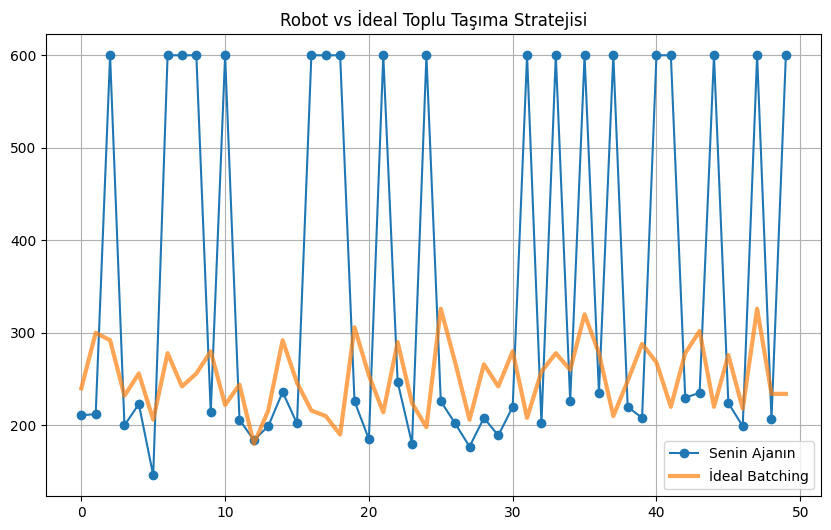

In [5]:
import matplotlib.pyplot as plt
from collections import deque

# BFS (Mesafe ölçer)
def bfs_shortest_path(grid_map, start, target_val):
    rows, cols = grid_map.shape
    queue = deque([(start, 0)])
    visited = set()
    visited.add(tuple(start))
    targets = []
    for r in range(rows):
        for c in range(cols):
            if grid_map[r, c] == target_val:
                targets.append((r, c))
    while queue:
        (r, c), dist = queue.popleft()
        for tr, tc in targets:
            if r == tr and c == tc: return dist
        for dr, dc in [(-1,0), (1,0), (0,-1), (0,1)]:
            nr, nc = r + dr, c + dc
            if 0 <= nr < rows and 0 <= nc < cols:
                if grid_map[nr, nc] != 1 and (nr, nc) not in visited:
                    visited.add((nr, nc))
                    queue.append(((nr, nc), dist + 1))
    return 0

# İDEAL STRATEJİ HESAPLAYICI (BATCHING DAHİL)
def calculate_batch_ideal_steps(env):
    sim_pos = [0, 0]
    sim_slots = [0, 0]
    sim_orders = env.order_list.copy()
    total_steps = 0

    # Döngü: İş bitene kadar
    while len(sim_orders) > 0 or sum(sim_slots) > 0:

        # 1. Yükleme Stratejisi: Yer varsa Dock'a git ve FULLE
        if 0 in sim_slots and len(sim_orders) > 0:
            if sim_pos != [0, 0]:
                dist = bfs_shortest_path(env.map, sim_pos, 2)
                total_steps += dist
                sim_pos = [0, 0]

            # Kapasite dolana kadar yükle
            while 0 in sim_slots and len(sim_orders) > 0:
                empty_idx = sim_slots.index(0)
                sim_slots[empty_idx] = sim_orders.pop(0)

        # 2. Dağıtım Stratejisi: En yakındakine git
        elif sum(sim_slots) > 0:
            targets = []
            if sim_slots[0] > 0: targets.append((sim_slots[0], env.shelves[sim_slots[0]]))
            if sim_slots[1] > 0: targets.append((sim_slots[1], env.shelves[sim_slots[1]]))

            best_dist = 9999
            best_target_pos = None
            best_item_idx = -1

            for item_val, pos in targets:
                shelf_val = 10 + (item_val - 1)
                d = bfs_shortest_path(env.map, sim_pos, shelf_val)
                if d < best_dist:
                    best_dist = d
                    best_target_pos = pos
                    best_item_idx = 0 if sim_slots[0] == item_val else 1

            total_steps += best_dist
            sim_pos = list(best_target_pos)
            sim_slots[best_item_idx] = 0

    return total_steps

# TEST
print("Performans Analizi Yapılıyor (Batching Stratejisi)...")
test_episodes = 50
agent_scores = []
math_scores = []

for i in range(test_episodes):
    obs = env.reset()
    state = get_state_key(obs)
    done = False
    agent_steps = 0

    ideal_steps = calculate_batch_ideal_steps(env)
    math_scores.append(ideal_steps)

    while not done:
        if state in q_table: action = np.argmax(q_table[state])
        else: action = env.action_space.sample()
        obs, reward, done, _ = env.step(action)
        state = get_state_key(obs)
        agent_steps += 1
        if agent_steps > 800: break
    agent_scores.append(agent_steps)

avg_agent = np.mean(agent_scores)
avg_math = np.mean(math_scores)
efficiency = (avg_math / avg_agent) * 100

print(f"\n--- SONUÇ ---")
print(f"İdeal (Matematik): {avg_math:.1f}")
print(f"Ajan (RL): {avg_agent:.1f}")
print(f"Verimlilik: %{efficiency:.2f}")

plt.figure(figsize=(10, 6))
plt.plot(agent_scores, label='Senin Ajanın', marker='o')
plt.plot(math_scores, label='İdeal Batching', linewidth=3, alpha=0.7)
plt.title("Robot vs İdeal Toplu Taşıma Stratejisi")
plt.legend()
plt.grid(True)
plt.show()